## Libraries Required

In [1]:
#basic imports
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#NLP imports
import re
import time
import aranorm
import dialectUtils
import preprocess_arabert

##Classification imports
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTEN
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

#Models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB, BernoulliNB,GaussianNB
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier

In [2]:
dfTrain=pd.read_csv("preProcessedTweets_trainF.csv")
dfTrain.dropna(inplace=True)
dfValid=pd.read_csv("preProcessedTweets_validF.csv")
dfValid.dropna(inplace=True)
dfTest=pd.read_csv("preProcessedTweets_testF.csv")
dfTest.dropna(inplace=True)

In [3]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365723 entries, 0 to 365722
Data columns (total 2 columns):
text_preprocessed    365723 non-null object
label                365723 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.4+ MB


In [4]:
dfValid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45714 entries, 0 to 45714
Data columns (total 2 columns):
text_preprocessed    45714 non-null object
label                45714 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [5]:
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45716 entries, 0 to 45715
Data columns (total 2 columns):
text_preprocessed    45716 non-null object
label                45716 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [6]:
textTest=['@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .',
 '@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. حيونه ووحشيه .. وتطلبون من الغرب يحترمكم ويؤمن بدينكم ولاينعتكم بالإرهاب ..',
 '@KanaanRema مبين من كلامه خليجي',
 '@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐',
 '@hmo2406 وين هل الغيبه  اخ محمد 🌸🌺']

In [7]:
dialectUtils.tweet_preprcessing(textTest[0])

'لكن بالنهايه ينتفض يغير'

In [8]:
tweet=textTest[0]

In [10]:
df = pd.DataFrame({'T':textTest})
df['T'] = df['T'].apply(dialectUtils.tweet_preprcessing)

In [11]:
df

,T
0,لكن بالنهايه ينتفض يغير
1,يعني هذا محسوب علي البشر حيونه ووحشيه وتطلبون ...
2,مبين من كلامه خليجي
3,يسلملي مرورك وروحك الحلوه
4,وين هل الغيبه اخ محمد


In [12]:
keys_dictionary   = {0:"EG",1:"PL",2:"KW",3:"LY",4:"QA",5:"JO",6:"LB",7:"SA",8:"AE",9:"BH",
                     10:"OM",11:"SY",12:"DZ",13:"IQ",14:"SD",15:"MA",16:"YE",17:"TN"}

In [13]:
def predictC(tweet,model):
    df = pd.DataFrame({'T':[tweet]})
    df['T'] = df['T'].apply(dialectUtils.tweet_preprcessing)
    pred=model.predict(df['T']) 
    return keys_dictionary.get(pred[0])

In [14]:
Xtrain= dfTrain['text_preprocessed']
ytrain= dfTrain["label"].apply(int)

Xval  = dfValid['text_preprocessed']
yval  = dfValid["label"].apply(int)

Xtest = dfTest['text_preprocessed']
ytest = dfTest["label"].apply(int)

## Training Models without Resampling

### Approach 1: Naive Bayes Classifier for MultiNomial

In [15]:
nb = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, max_df=0.5,min_df=10)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=0.1))])

nb.fit(Xtrain, ytrain)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.1))])

In [19]:
y_pred_ValNB = nb.predict(Xval)

print('Train Accuracy:      ', round(nb.score(Xtrain, ytrain),2))
print('Validation Accuracy: ', round(accuracy_score(y_pred_ValNB, yval),2))
print("---"*20)
s=time.time()
y_pred_TestNB= nb.predict(Xtest)
print('Test Accuracy:       ', round(accuracy_score(y_pred_TestNB, ytest),2))
e=time.time()
print("It took",round((e-s),4)," Second for Inference on Test Data")
print("---"*20)
print("Classification Report for Test Data by **Naive Bayes Classifier for MultiNomial**:\n"+"-"*80)
print(classification_report(ytest, y_pred_TestNB))

Train Accuracy:       0.71
Validation Accuracy:  0.51
------------------------------------------------------------
Test Accuracy:        0.51
It took 1.6552  Second for Inference on Test Data
------------------------------------------------------------
Classification Report for Test Data by **Naive Bayes Classifier for MultiNomial**:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.87      0.73      5756
           1       0.42      0.58      0.49      4368
           2       0.41      0.60      0.48      4200
           3       0.62      0.68      0.65      3647
           4       0.42      0.47      0.44      3105
           5       0.38      0.26      0.31      2784
           6       0.63      0.64      0.63      2757
           7       0.42      0.39      0.40      2678
           8       0.41      0.38      0.39      2620
           9       0.34      0.29      0.3

In [22]:
print("Number of mislabeled points out of a total %d points : %d" % (Xtest.shape[0], (ytest != nb.predict(Xtest)).sum()))

Number of mislabeled points out of a total 45716 points : 22442


### Approach 2: Naive Bayes Classifier for BernoulliNB

In [20]:
br = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, max_df=0.5,min_df=10)),
               ('tfidf', TfidfTransformer()),
               ('clf', BernoulliNB(alpha=0.1))])

br.fit(Xtrain, ytrain)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('tfidf', TfidfTransformer()),
                ('clf', BernoulliNB(alpha=0.1))])

In [21]:
y_pred_ValBR = br.predict(Xval)

print('Train Accuracy:      ', round(br.score(Xtrain, ytrain),2))
print('Validation Accuracy: ', round(accuracy_score(y_pred_ValBR, yval),2))

print("---"*20)
s=time.time()
y_pred_TestBR= br.predict(Xtest)
print('Test Accuracy:       ', round(accuracy_score(y_pred_TestBR, ytest),2))
e=time.time()
print("It took",round((e-s),4)," Second for Inference on Test Data")
print("---"*20)

print("Classification Report for Test Data by **Naive Bayes Classifier for BernoulliNB**:\n"+"-"*80)
print(classification_report(ytest, y_pred_TestBR))

Train Accuracy:       0.69
Validation Accuracy:  0.52
------------------------------------------------------------
Test Accuracy:        0.52
It took 1.9579  Second for Inference on Test Data
------------------------------------------------------------
Classification Report for Test Data by **Naive Bayes Classifier for BernoulliNB**:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      5756
           1       0.43      0.56      0.49      4368
           2       0.54      0.48      0.51      4200
           3       0.64      0.69      0.66      3647
           4       0.51      0.42      0.46      3105
           5       0.38      0.31      0.34      2784
           6       0.68      0.61      0.64      2757
           7       0.43      0.41      0.42      2678
           8       0.44      0.38      0.41      2620
           9       0.30      0.38      0.3

In [23]:
print("Number of mislabeled points out of a total %d points : %d" % (Xtest.shape[0], (ytest != br.predict(Xtest)).sum()))

Number of mislabeled points out of a total 45716 points : 22127


### Approach 3: SGD Classifier and Loss Function is `hinge`, which gives a `linear SVM`.

In [24]:
sgd = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, max_df=0.5,min_df=1)),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge',random_state=0))])

sgd.fit(Xtrain, ytrain)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=0))])

In [25]:
y_pred_ValSGD = sgd.predict(Xval)

print('Train Accuracy:      ', round(sgd.score(Xtrain, ytrain),2))
print('Validation Accuracy: ', round(accuracy_score(y_pred_ValSGD, yval),2))

print("---"*20)
s=time.time()
y_pred_TestSGD= sgd.predict(Xtest)
print('Test Accuracy:       ', round(accuracy_score(y_pred_TestSGD, ytest),2))
e=time.time()
print("It took",round((e-s),4)," Second for Inference on Test Data")
print("---"*20)

print("Classification Report for Test Data by **SGD Classifier**:\n"+"-"*80)
print(classification_report(ytest, y_pred_TestSGD))

Train Accuracy:       0.95
Validation Accuracy:  0.53
------------------------------------------------------------
Test Accuracy:        0.53
It took 2.9549  Second for Inference on Test Data
------------------------------------------------------------
Classification Report for Test Data by **SGD Classifier**:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.94      0.66      5756
           1       0.51      0.49      0.50      4368
           2       0.48      0.63      0.54      4200
           3       0.63      0.70      0.66      3647
           4       0.48      0.48      0.48      3105
           5       0.46      0.25      0.32      2784
           6       0.56      0.73      0.63      2757
           7       0.47      0.40      0.43      2678
           8       0.48      0.39      0.43      2620
           9       0.48      0.28      0.36      2612
          10

In [26]:
print("Number of mislabeled points out of a total %d points : %d" % (Xtest.shape[0], (ytest != sgd.predict(Xtest)).sum()))

Number of mislabeled points out of a total 45716 points : 21510


### Approach 4: LinearSVC Classifier and Balanced Class Weight

In [27]:
lsvm = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, max_df=0.5,min_df=1)),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC(random_state=0, tol=1e-5,class_weight="balanced"))])

lsvm.fit(Xtrain, ytrain)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LinearSVC(class_weight='balanced', random_state=0,
                           tol=1e-05))])

In [28]:
y_pred_ValLSVM = lsvm.predict(Xval)

print('Train Accuracy:      ', round(lsvm.score(Xtrain, ytrain),2))
print('Validation Accuracy: ', round(accuracy_score(y_pred_ValLSVM, yval),2))

print("---"*20)
s=time.time()
y_pred_TestLSVM= lsvm.predict(Xtest)
print('Test Accuracy:       ', round(accuracy_score(y_pred_TestLSVM, ytest),2))
e=time.time()
print("It took",round((e-s),4)," Second for Inference on Test Data")
print("---"*20)

print("Classification Report for Test Data by **LinearSVC Classifier and Balanced Class Weight**:\n"+"-"*80)
print(classification_report(ytest, y_pred_TestLSVM))

Train Accuracy:       1.0
Validation Accuracy:  0.57
------------------------------------------------------------
Test Accuracy:        0.57
It took 2.5965  Second for Inference on Test Data
------------------------------------------------------------
Classification Report for Test Data by **LinearSVC Classifier and Balanced Class Weight**:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.88      0.78      5756
           1       0.54      0.52      0.53      4368
           2       0.53      0.60      0.56      4200
           3       0.73      0.72      0.73      3647
           4       0.48      0.51      0.50      3105
           5       0.44      0.36      0.39      2784
           6       0.62      0.71      0.67      2757
           7       0.45      0.48      0.46      2678
           8       0.45      0.46      0.46      2620
           9       0.42      0.34  

In [29]:
print("Number of mislabeled points out of a total %d points : %d" % (Xtest.shape[0], (ytest != lsvm.predict(Xtest)).sum()))

Number of mislabeled points out of a total 45716 points : 19763


##### As we See that seems LinearSVC Classifier is the best as it is recommended in the Paper and because LinearSVC tends to be faster to converge the larger the number of samples and it is actually minimizing squared hinge loss, instead of just hinge loss.

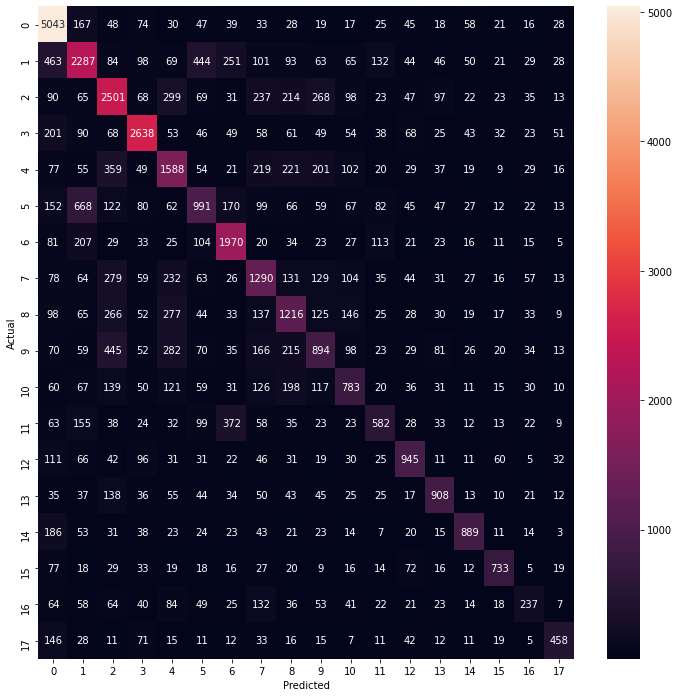

In [31]:
conf_mat = confusion_matrix(ytest, lsvm.predict(Xtest))
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [32]:
print("Number of mislabeled points out of a total %d points : %d" % (Xtest.shape[0], (ytest != lsvm.predict(Xtest)).sum()))

Number of mislabeled points out of a total 45716 points : 19763


In [33]:
print(classification_report(ytest, lsvm.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.71      0.88      0.78      5756
           1       0.54      0.52      0.53      4368
           2       0.53      0.60      0.56      4200
           3       0.73      0.72      0.73      3647
           4       0.48      0.51      0.50      3105
           5       0.44      0.36      0.39      2784
           6       0.62      0.71      0.67      2757
           7       0.45      0.48      0.46      2678
           8       0.45      0.46      0.46      2620
           9       0.42      0.34      0.38      2612
          10       0.46      0.41      0.43      1904
          11       0.48      0.36      0.41      1621
          12       0.60      0.59      0.59      1614
          13       0.61      0.59      0.60      1548
          14       0.69      0.62      0.65      1438
          15       0.69      0.64      0.66      1153
          16       0.38      0.24      0.29       988
          17       0.62    

In [ ]:
Original:   وكل سنه وكل يوم وانت سالم وسط عيلتك ومحبيك
Tokenized:  ['وكل', 'سنه', 'وكل', 'يوم', 'وانت', 'سالم', 'وسط', 'عي', '##لتك', 'ومحبي', '##ك']
Token IDs:  [8465, 16278, 485, 3998, 6804, 209, 3651, 25697, 24325, 740, 14247]

In [34]:
import joblib
joblib.dump(lsvm, 'LinearSVC_model.pkl')

['LinearSVC_model.pkl']

__________________________________________________________________________________________________________________________